In [3]:
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import QPP_Funcs as qpp
import celerite as ce
import os
from celerite.solver import LinAlgError
import dynesty
from dynesty import utils as dyfunc

SHO_prior_bounds  = [(np.log(1), np.log(1e7)),(np.log(2), np.log(20)), (2, 7)]
CTSModel_prior_bounds  = [(np.log(1), np.log(1e7)), (np.log(1), np.log(1e4)), (np.log(1), np.log(1e7)), (-10, 10)]
RealTerm_prior_bounds  = [(-20,20), (-20,10)]

bound_vec = SHO_prior_bounds  + CTSModel_prior_bounds
bound_vec2 = RealTerm_prior_bounds + CTSModel_prior_bounds
prior_transform = qpp.make_prior_transform(bound_vec)
prior_transform2 = qpp.make_prior_transform(bound_vec2)


s0 = np.linspace(np.log(2), np.log(9e6),5)
q = np.linspace(np.log(3), np.log(19),5)

datadir = "Data/Simulating/08282018/"
loc = (datadir + "simulated_burst_")

Exists at: Data/Simulating/08172018/simulated_burst_S0.69Q1.10w3.00/
Exists at: Data/Simulating/08172018/simulated_burst_S0.69Q1.30w3.00/
Exists at: Data/Simulating/08172018/simulated_burst_S0.69Q1.51w3.00/
Exists at: Data/Simulating/08172018/simulated_burst_S0.69Q1.71w3.00/
Running S: 0.6931471805599453	Q: 1.9189797066673677
Saving at: Data/Simulating/08172018/simulated_burst_S0.69Q1.92w3.00/

Sampling2 ...


iter: 33172 | batch: 3 | bound: 1895 | nc: 25 | ncall: 1388041 | eff(%):  2.390 | loglstar: -13431.552 < -13422.896 < -13429.768 | logz: -13466.296 +/-    nan | stop:  0.997                 


Sampling1 ...


iter: 20981 | batch: 0 | bound: 1254 | nc: 25 | ncall: 824990 | eff(%):  2.542 | loglstar:   -inf < -13426.088 <    inf | logz: -13468.655 +/-    nan | dlogz:  6.010 >  0.010                

KeyboardInterrupt: 

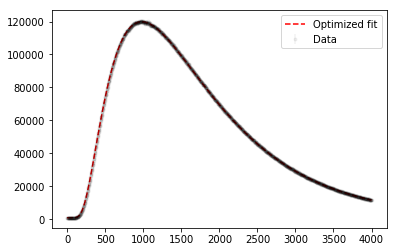

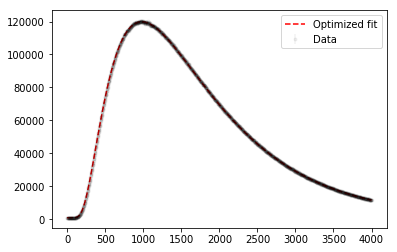

In [14]:
for s0i in s0:
    for qi in q:
        qpoparams = [s0i, qi, 3]
        qpolabel = "S{:1.2f}".format(qpoparams[0])+"Q{:1.2f}".format(qpoparams[1])+"w{:1.2f}".format(qpoparams[2])
        fname = loc + qpolabel+"/"
        if os.path.exists(fname):
            print("Exists at: " + fname)
            continue
        print("Running S: " + str(s0i) + "\tQ: "+ str(qi)  +"\nSaving at: " + fname + '\n')
        qpoparams = [s0i, qi, 3]
        realparams = [-.13, -1.4] 
        modelparams = [11.33844804, 6.92311406, 6.85207764, np.log(1000)]
        trueparams = qpoparams + modelparams
        ndim = len(trueparams)
        ndim2 = len(bound_vec2)
                
        model = qpp.CTSModel_prior(log_A = modelparams[0], log_tau1 = modelparams[1], log_tau2 = modelparams[2], log_bkg = modelparams[3])
        kernel1 = qpp.SHOTerm_Prior(log_S0 = qpoparams[0], log_Q = qpoparams[1], log_omega0 = qpoparams[2])
        kernel2 = qpp.RealTerm_Prior(log_a = realparams[0], log_c = realparams[1])
        kernel = kernel1

        t = np.linspace(0,4000,2000)
        I = qpp.simulate(t, model, kernel, noisy = True)



        A_guess, t1_guess, t2_guess = qpp.initguess(t,I)
        model = qpp.CTSModel_prior(log_A = np.log(A_guess), log_tau1 = np.log(t1_guess), log_tau2 = np.log(t2_guess), log_bkg = np.log(1000))
        kernel1 = qpp.SHOTerm_Prior(log_S0 = np.log(3), log_Q = np.log(3), log_omega0 = 3) #write guesser for kernel parameters
        kernel2 = qpp.RealTerm_Prior(log_a=0., log_c=0.) #write guesser for kernel parameters
        kernel = kernel1
        gp = ce.GP(kernel, mean=model, fit_mean=True)
        gp.compute(t, np.sqrt(I))
        initparams = gp.get_parameter_vector()
        
        gp2 = ce.GP(kernel2, mean=model, fit_mean=True)
        gp2.compute(t, np.sqrt(I))
        initparams2 = gp.get_parameter_vector()

        loglike = qpp.make_loglike(I, gp)
        loglike2 = qpp.make_loglike(I, gp2)

        soln = qpp.optimize_gp(gp, I)
        gp.set_parameter_vector(soln.x)
        figopt = qpp.plot_gp(t, I, np.sqrt(I), gp, model, predict=True, label = "Optimized fit", flat=True)

        soln2 = qpp.optimize_gp(gp2, I)
        gp2.set_parameter_vector(soln2.x)
        figopt2 = qpp.plot_gp(t, I, np.sqrt(I), gp2, model, predict=True, label = "Optimized fit", flat=True)
        
        sampler =  dynesty.DynamicNestedSampler(loglike, prior_transform, ndim, bound="multi", sample="rwalk", nlive=1000)
        sampler2 =  dynesty.DynamicNestedSampler(loglike2, prior_transform2, ndim2, bound="multi", sample="rwalk", nlive=1000)

        print "Sampling2 ..."
        sampler2.run_nested()
        res2 = sampler2.results
        bayesfac2 = res2.logz[-1:]
        samples2, weights2 = res2.samples, np.exp(res2.logwt-res2.logz[-1])
        chain2 = dyfunc.resample_equal(samples2, weights2)
        
        print "Sampling1 ..."
        sampler.run_nested()
        res = sampler.results
        bayesfac = res.logz[-1:]
        samples, weights = res.samples, np.exp(res.logwt-res.logz[-1])
        chain = dyfunc.resample_equal(samples, weights)
        
        
        
        print "Ohheck"
        #figsam = qpp.plot_chain(chain, labels = gp.get_parameter_names(), burstid = qpolabel, flat=True)

        try:
            figoptsam = qpp.plot_gp(t, I, np.sqrt(I), gp, model, chain=chain, burstid = qpolabel, predict=True, flat=True)
        except LinAlgError:
            figoptsam = qpp.plot_gp(t, I, np.sqrt(I), gp, model, chain=chain, burstid = qpolabel, predict=True, flat=True)

        try:
            figoptsam2 = qpp.plot_gp(t, I, np.sqrt(I), gp2, model, chain=chain2, burstid = qpolabel, predict=True, flat=True)
        except LinAlgError:
            figoptsam2 = qpp.plot_gp(t, I, np.sqrt(I), gp2, model, chain=chain2, burstid = qpolabel, predict=True, flat=True)
   
            
            
        figcorner, maxparams = qpp.plot_corner(chain, labels = gp.get_parameter_names(), truevals = trueparams, burstid = qpolabel, flat=True)
        figcorner2, maxparams2 = qpp.plot_corner(chain2, labels = gp2.get_parameter_names(), burstid = qpolabel, flat=True)
        bayesresult = bayesfac-bayesfac2

        header = "Rednoise Kernel Params: \t"+str(realparams) + "\nQPO Params: \t" + str(qpoparams) + "\nEnvelope Params \t" + str(modelparams) + "\nTrue Parameter Vector: \t" + str(trueparams) + "\nMaxParams: \t" + str(maxparams) + "\nBayes Factor: \t" + str(bayesresult)
        fname = loc + qpolabel+"z/"

        if not os.path.exists(fname):
            os.makedirs(fname)
            
            qpp.store_flare(fname+"data", header, t, I, soln.x, chain)
            figoptsam.savefig(fname+"lc_plot.png")
            figcorner.savefig(fname+"chain_corner.png")
            
            qpp.store_flare(fname+"data2", header, t, I, soln2.x, chain2)
            figoptsam2.savefig(fname+"lc_plot2.png")
            figcorner2.savefig(fname+"chain_corner2.png")
            
            
            textheader = open(fname+"header.txt",'w')
            textheader.write(header)
            textheader.close()
        else:
            print "directory exists"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import QPP_Funcs as qpp
import celerite as ce

import glob, ast
files =  glob.glob(datadir+"*")
dim = int(np.sqrt(len(files)))
qpoparam_array = []
oparam_array = []
chain_array = []
I_array = []
SHO_prior_bounds  = [(np.log(1), np.log(1e7)),(np.log(2), np.log(20)), (2, 7)]


print("Sorting Data...")

for i in range(len(files)):
    loc = files[i]+'/data'
    head, t, I, oparams, chain = qpp.load_flare(loc)
    p1 = head.partition('QPO Params: \t')
    p2 = p1[2].partition('\n')
    qpoparams = ast.literal_eval(p2[0])
    chain = np.array(chain)    
    oparam_array.append(oparams)
    qpoparam_array.append(qpoparams)
    chain_array.append(chain)
    I_array.append(I)

t = np.linspace(0,4000,2000)
oparam_array = np.array(oparam_array)
qpoparam_array = np.array(qpoparam_array)
chain_array = np.array(chain_array)
I_array = np.array(I_array)
    
oparams_grid = [[None for _ in range(dim)] for _ in range(dim)]
qpoparams_grid = [[None for _ in range(dim)] for _ in range(dim)]
chain_grid = [[None for _ in range(dim)] for _ in range(dim)]
I_grid = [[None for _ in range(dim)] for _ in range(dim)]
    
sort_array = np.argsort(qpoparam_array, axis=0)
for i in range(len(sort_array)):
    oparams_grid[i/dim][i%dim] = oparam_array[sort_array[i][0]]
    qpoparams_grid[i/dim][i%dim] = qpoparam_array[sort_array[i][0]]
    chain_grid[i/dim][i%dim] = chain_array[sort_array[i][0]]
    I_grid[i/dim][i%dim] = I_array[sort_array[i][0]]


qpoparams = [1, 1, 3]
realparams = [-.13, -1.4] 
modelparams = [11.33844804, 6.92311406, 6.85207764, np.log(1000)]
model = qpp.CTSModel_prior(log_A = modelparams[0], log_tau1 = modelparams[1], log_tau2 = modelparams[2], log_bkg = modelparams[3])
kernel1 = qpp.SHOTerm_Prior(log_S0 = qpoparams[0], log_Q = qpoparams[1], log_omega0 = qpoparams[2])
#kernel2 = qpp.RealTerm_Prior(log_a = realparams[0], log_c = realparams[1])
kernel = kernel1
gp = ce.GP(kernel, mean=model, fit_mean=True)
print gp.get_parameter_names()

In [ ]:
gridfig, gridax = plt.subplots(nrows = dim, ncols = dim, sharex=True, sharey=True, squeeze=True, figsize=(20,20))
curvefig, curveax = plt.subplots(nrows = dim, ncols = dim, figsize=(20,20))
postfig, postax = plt.subplots(nrows = dim, ncols = dim, figsize=(20,20))

gridfig.text(0.5, 0.04, 'Power Factor $S_0$', ha='center')
gridfig.text(0.04, 0.5, 'Quality Factor $Q$', va='center', rotation='vertical')

print("Plotting results...")
sort_array = np.argsort(qpoparams_grid, axis=1)
for i in range(dim):
    for j in range(dim):
        print("Plot " + str((dim*i)+j+1))
        index = sort_array[i][j][1]
        chain = chain_grid[i][index]
        I = I_grid[i][index]
        oparams = oparams_grid[i][index]
        params = qpoparams_grid[i][index]
        s0_chain = chain[:,0]
        Q_chain = chain[:,1]
        bounds = [[SHO_prior_bounds[0][0],SHO_prior_bounds[0][1]],[SHO_prior_bounds[1][0], SHO_prior_bounds[1][1]]]
        gridax[j,i].hist2d(s0_chain, Q_chain,bins=50, range = bounds, normed=True)
        gridax[j,i].plot(params[0], params[1], 'r.')
        name = "$S_0$:{0:.2f}".format(params[0])+", Q: {0:.2f}".format(params[1])
        gridax[j,i].set_title(name)
        gp.compute(t, np.sqrt(I))

        for k in range(8):
            oparams = chain[np.random.randint(len(chain)-1)]
            gp.set_parameter_vector(oparams)
            model.set_parameter_vector(oparams[-len(gp.mean.get_parameter_vector()):])
            sample = gp.sample_conditional(I,t)
            postax[j,i].plot(t,sample, 'g', alpha=.2)

        gp.set_parameter_vector(oparams)
        model.set_parameter_vector(oparams[-len(gp.mean.get_parameter_vector()):])
        #curveax[j,i].plot(t, I, 'k.', alpha = 0.05)
        curveax[j,i].plot(t, gp.mean.get_value(t), 'r--')
        curveax[j,i].set_title(name)
        
plt.show()
    

In [ ]:
#%matplotlib notebook
plt.get_backend()

In [ ]:
%load_ext autoreload
%autoreload 2
import QPP_Funcs as qpp

In [ ]:
gp.mean.get_parameter_vector()